**8.6 토픽 모델링**

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# 모토사이클, 야구, 그래픽스, 윈도우즈, 중동, 기독교, 의학, 우주 주제를 추출. 
cats = ['rec.motorcycles', 'rec.sport.baseball', 'comp.graphics', 'comp.windows.x',
        'talk.politics.mideast', 'soc.religion.christian', 'sci.electronics', 'sci.med'  ]

# 위에서 cats 변수로 기재된 category만 추출. featch_20newsgroups( )의 categories에 cats 입력
news_df= fetch_20newsgroups(subset='all',remove=('headers', 'footers', 'quotes'), 
                            categories=cats, random_state=0)

#LDA 는 Count기반의 Vectorizer만 적용합니다.  
count_vect = CountVectorizer(max_df=0.95, max_features=1000, min_df=2, stop_words='english', ngram_range=(1,2))
feat_vect = count_vect.fit_transform(news_df.data)
print('CountVectorizer Shape:', feat_vect.shape)

CountVectorizer Shape: (7862, 1000)


In [2]:
lda = LatentDirichletAllocation(n_components=8, random_state=0)
lda.fit(feat_vect)

LatentDirichletAllocation(n_components=8, random_state=0)

In [3]:
print(lda.components_.shape)
lda.components_

(8, 1000)


array([[3.60992018e+01, 1.35626798e+02, 2.15751867e+01, ...,
        3.02911688e+01, 8.66830093e+01, 6.79285199e+01],
       [1.25199920e-01, 1.44401815e+01, 1.25045596e-01, ...,
        1.81506995e+02, 1.25097844e-01, 9.39593286e+01],
       [3.34762663e+02, 1.25176265e-01, 1.46743299e+02, ...,
        1.25105772e-01, 3.63689741e+01, 1.25025218e-01],
       ...,
       [3.60204965e+01, 2.08640688e+01, 4.29606813e+00, ...,
        1.45056650e+01, 8.33854413e+00, 1.55690009e+01],
       [1.25128711e-01, 1.25247756e-01, 1.25005143e-01, ...,
        9.17278769e+01, 1.25177668e-01, 3.74575887e+01],
       [5.49258690e+01, 4.47009532e+00, 9.88524814e+00, ...,
        4.87048440e+01, 1.25034678e-01, 1.25074632e-01]])

In [33]:
def display_topics(model, feature_names, no_top_words):
    for topic_index, topic in enumerate(model.components_):
        print('Topic #',topic_index)

        # components_ array에서 가장 값이 큰 순으로 정렬했을 때, 그 값의 array index를 반환. 
        topic_word_indexes = topic.argsort()[::-1]
        top_indexes=topic_word_indexes[:no_top_words]
        
        # top_indexes대상인 index별로 feature_names에 해당하는 word feature 추출 후 join으로 concat
        feature_concat = ' '.join([feature_names[i] for i in top_indexes])                
        print(feature_concat)

# CountVectorizer객체내의 전체 word들의 명칭을 get_features_names( )를 통해 추출
feature_names = count_vect.get_feature_names_out()

# Topic별 가장 연관도가 높은 word를 15개만 추출
display_topics(lda, feature_names, 15)

Topic # 0
year 10 game medical health team 12 20 disease cancer 1993 games years patients good
Topic # 1
don just like know people said think time ve didn right going say ll way
Topic # 2
image file jpeg program gif images output format files color entry 00 use bit 03
Topic # 3
like know don think use does just good time book read information people used post
Topic # 4
armenian israel armenians jews turkish people israeli jewish government war dos dos turkey arab armenia 000
Topic # 5
edu com available graphics ftp data pub motif mail widget software mit information version sun
Topic # 6
god people jesus church believe christ does christian say think christians bible faith sin life
Topic # 7
use dos thanks windows using window does display help like problem server need know run


**8.7 Opinion Review 데이터 세트를 이용한 문서 군집화 수행하기**

In [18]:
import pandas as pd
import glob ,os

path = './OpinosisDataset/topics'                     
# path로 지정한 디렉토리 밑에 있는 모든 .data 파일들의 파일명을 리스트로 취합
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

# 개별 파일들의 파일명은 filename_list 리스트로 취합, 
# 개별 파일들의 파일내용은 DataFrame로딩 후 다시 string으로 변환하여 opinion_text 리스트로 취합 
for file_ in all_files:
    # 개별 파일을 읽어서 DataFrame으로 생성 
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    
    # Extract the file name without the path and extension
    filename_ = os.path.basename(file_)
    filename = os.path.splitext(filename_)[0]
    
    # Convert the DataFrame content to a string and add it to the list
    opinion_text.append(' '.join(df.iloc[:, 0].astype(str)))
    filename_list.append(filename)

# 파일명 리스트와 파일내용 리스트를  DataFrame으로 생성
document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})
document_df.head()

,filename,opinion_text
0,battery-life_ipod_nano_8gb.txt,I love this ipod except for the battery life ....
1,gas_mileage_toyota_camry_2007.txt,It gets great gas mileage . Being a mother...
2,room_holiday_inn_london.txt,We had a room with two double beds which was ...
3,location_holiday_inn_london.txt,"All in all, a normal chain hotel on a nice loc..."
4,staff_bestwestern_hotel_sfo.txt,The staff in the morning seemed to need anoth...


In [19]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('wordnet')

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/hyejinpark/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/hyejinpark/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )

#opinion_text 컬럼값으로 feature vectorization 수행
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [21]:
from sklearn.cluster import KMeans

# 5개 집합으로 군집화 수행. 예제를 위해 동일한 클러스터링 결과 도출용 random_state=0 
km_cluster = KMeans(n_clusters=5, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_

In [22]:
document_df['cluster_label'] = cluster_label
document_df.head()

,filename,opinion_text,cluster_label
0,battery-life_ipod_nano_8gb.txt,I love this ipod except for the battery life ....,1
1,gas_mileage_toyota_camry_2007.txt,It gets great gas mileage . Being a mother...,4
2,room_holiday_inn_london.txt,We had a room with two double beds which was ...,3
3,location_holiday_inn_london.txt,"All in all, a normal chain hotel on a nice loc...",0
4,staff_bestwestern_hotel_sfo.txt,The staff in the morning seemed to need anoth...,3


In [23]:
document_df[document_df['cluster_label']==0].sort_values(by='filename')

,filename,opinion_text,cluster_label
17,food_holiday_inn_london.txt,The over zealous staff cleared our unfinish...,0
32,food_swissotel_chicago.txt,The food in the lounge was great and very fre...,0
3,location_holiday_inn_london.txt,"All in all, a normal chain hotel on a nice loc...",0
41,price_amazon_kindle.txt,"lower overall price, with nice leather cover ...",0
28,price_holiday_inn_london.txt,Great Price Terrific Location . Our main focus...,0
16,service_bestwestern_hotel_sfo.txt,"The service was good, very friendly staff and...",0
27,service_holiday_inn_london.txt,"The room was quiet, clean, the bed and pillows...",0
13,service_swissotel_hotel_chicago.txt,The accomodations and support services are ph...,0


In [24]:
document_df[document_df['cluster_label']==1].sort_values(by='filename')

,filename,opinion_text,cluster_label
33,accuracy_garmin_nuvi_255W_gps.txt,"but for the most part, we find that the Garmi...",1
9,battery-life_amazon_kindle.txt,"After you have paged tru a 500, page book one...",1
0,battery-life_ipod_nano_8gb.txt,I love this ipod except for the battery life ....,1
11,battery-life_netbook_1005ha.txt,Not to mention that as of now Asus will not s...,1
26,buttons_amazon_kindle.txt,As soon as I'd clicked the button to confirm ...,1
34,directions_garmin_nuvi_255W_gps.txt,I used to hesitate to go out of my directions...,1
48,display_garmin_nuvi_255W_gps.txt,This made for smoother graphics on the 255w o...,1
36,eyesight-issues_amazon_kindle.txt,"the white is really GREY, and to avoid consid...",1
21,features_windows7.txt,This review briefly touches upon some of the ...,1
44,fonts_amazon_kindle.txt,"For whatever reason, Amazon decided to make t...",1


In [25]:
document_df[document_df['cluster_label']==2].sort_values(by='filename')

,filename,opinion_text,cluster_label
45,interior_honda_accord_2008.txt,"However, there are a couple of things that ki...",2
22,interior_toyota_camry_2007.txt,"3 blown struts at 30,000 miles, interior trim...",2
42,quality_toyota_camry_2007.txt,I bought the Camry because of Toyota reliabili...,2


In [26]:
document_df[document_df['cluster_label']==3].sort_values(by='filename')

,filename,opinion_text,cluster_label
31,bathroom_bestwestern_hotel_sfo.txt,"The second room was smaller, with a very inco...",3
49,free_bestwestern_hotel_sfo.txt,They also have a computer available with free...,3
39,location_bestwestern_hotel_sfo.txt,"Great Location , Nice Rooms , Helpless Con...",3
50,parking_bestwestern_hotel_sfo.txt,there is a fee for parking but well worth it ...,3
2,room_holiday_inn_london.txt,We had a room with two double beds which was ...,3
46,rooms_bestwestern_hotel_sfo.txt,"The rooms were bright, clean and the windows ...",3
30,rooms_swissotel_chicago.txt,The rooms look like they were just remodled a...,3
4,staff_bestwestern_hotel_sfo.txt,The staff in the morning seemed to need anoth...,3
20,staff_swissotel_chicago.txt,Each time I waited at the counter for staff ...,3


In [27]:
document_df[document_df['cluster_label']==4].sort_values(by='filename')

,filename,opinion_text,cluster_label
18,comfort_honda_accord_2008.txt,"It's very comfortable, remarkably large insid...",4
43,comfort_toyota_camry_2007.txt,"Seats are fine, in fact of all the smaller se...",4
1,gas_mileage_toyota_camry_2007.txt,It gets great gas mileage . Being a mother...,4
35,mileage_honda_accord_2008.txt,"The mileage is great, and I've had to get use...",4
47,performance_honda_accord_2008.txt,"6, 4, 3 eco engine has poor performance and g...",4
29,seats_honda_accord_2008.txt,"No memory seats, no trip computer, can only d...",4
23,transmission_toyota_camry_2007.txt,I wonder if the people who have problems with...,4


In [28]:
from sklearn.cluster import KMeans

# 3개의 집합으로 군집화 
km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_

# 소속 클러스터를 cluster_label 컬럼으로 할당하고 cluster_label 값으로 정렬
document_df['cluster_label'] = cluster_label
document_df.sort_values(by='cluster_label')

,filename,opinion_text,cluster_label
50,parking_bestwestern_hotel_sfo.txt,there is a fee for parking but well worth it ...,0
27,service_holiday_inn_london.txt,"The room was quiet, clean, the bed and pillows...",0
28,price_holiday_inn_london.txt,Great Price Terrific Location . Our main focus...,0
30,rooms_swissotel_chicago.txt,The rooms look like they were just remodled a...,0
20,staff_swissotel_chicago.txt,Each time I waited at the counter for staff ...,0
31,bathroom_bestwestern_hotel_sfo.txt,"The second room was smaller, with a very inco...",0
32,food_swissotel_chicago.txt,The food in the lounge was great and very fre...,0
17,food_holiday_inn_london.txt,The over zealous staff cleared our unfinish...,0
16,service_bestwestern_hotel_sfo.txt,"The service was good, very friendly staff and...",0
13,service_swissotel_hotel_chicago.txt,The accomodations and support services are ph...,0


In [29]:
cluster_centers = km_cluster.cluster_centers_
print('cluster_centers shape :',cluster_centers.shape)
print(cluster_centers)

cluster_centers shape : (3, 4391)
[[0.         0.         0.0041835  ... 0.         0.00183389 0.00144729]
 [0.01024691 0.01015348 0.00127425 ... 0.00713275 0.         0.        ]
 [0.         0.         0.00087573 ... 0.         0.         0.        ]]


In [30]:
# 군집별 top n 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명들을 반환함. 
def get_cluster_details(cluster_model, cluster_data, feature_names, clusters_num, top_n_features=10):
    cluster_details = {}
    
    # cluster_centers array 의 값이 큰 순으로 정렬된 index 값을 반환
    # 군집 중심점(centroid)별 할당된 word 피처들의 거리값이 큰 순으로 값을 구하기 위함.  
    centroid_feature_ordered_ind = cluster_model.cluster_centers_.argsort()[:,::-1]
    
    #개별 군집별로 iteration하면서 핵심단어, 그 단어의 중심 위치 상대값, 대상 파일명 입력
    for cluster_num in range(clusters_num):
        # 개별 군집별 정보를 담을 데이터 초기화. 
        cluster_details[cluster_num] = {}
        cluster_details[cluster_num]['cluster'] = cluster_num
        
        # cluster_centers_.argsort()[:,::-1] 로 구한 index 를 이용하여 top n 피처 단어를 구함. 
        top_feature_indexes = centroid_feature_ordered_ind[cluster_num, :top_n_features]
        top_features = [ feature_names[ind] for ind in top_feature_indexes ]
        
        # top_feature_indexes를 이용해 해당 피처 단어의 중심 위치 상댓값 구함 
        top_feature_values = cluster_model.cluster_centers_[cluster_num, top_feature_indexes].tolist()
        
        # cluster_details 딕셔너리 객체에 개별 군집별 핵심 단어와 중심위치 상대값, 그리고 해당 파일명 입력
        cluster_details[cluster_num]['top_features'] = top_features
        cluster_details[cluster_num]['top_features_value'] = top_feature_values
        filenames = cluster_data[cluster_data['cluster_label'] == cluster_num]['filename']
        filenames = filenames.values.tolist()
        cluster_details[cluster_num]['filenames'] = filenames
        
    return cluster_details

In [31]:
def print_cluster_details(cluster_details):
    for cluster_num, cluster_detail in cluster_details.items():
        print('####### Cluster {0}'.format(cluster_num))
        print('Top features:', cluster_detail['top_features'])
        print('Reviews 파일명 :',cluster_detail['filenames'][:7])
        print('==================================================')

In [34]:
feature_names = tfidf_vect.get_feature_names_out()

cluster_details = get_cluster_details(cluster_model=km_cluster, cluster_data=document_df,\
                                  feature_names=feature_names, clusters_num=3, top_n_features=10 )
print_cluster_details(cluster_details)

####### Cluster 0
Top features: ['room', 'hotel', 'service', 'staff', 'food', 'location', 'bathroom', 'clean', 'price', 'parking']
Reviews 파일명 : ['room_holiday_inn_london.txt', 'location_holiday_inn_london.txt', 'staff_bestwestern_hotel_sfo.txt', 'service_swissotel_hotel_chicago.txt', 'service_bestwestern_hotel_sfo.txt', 'food_holiday_inn_london.txt', 'staff_swissotel_chicago.txt']
####### Cluster 1
Top features: ['screen', 'battery', 'keyboard', 'battery life', 'life', 'kindle', 'direction', 'video', 'size', 'voice']
Reviews 파일명 : ['battery-life_ipod_nano_8gb.txt', 'voice_garmin_nuvi_255W_gps.txt', 'speed_garmin_nuvi_255W_gps.txt', 'size_asus_netbook_1005ha.txt', 'screen_garmin_nuvi_255W_gps.txt', 'battery-life_amazon_kindle.txt', 'satellite_garmin_nuvi_255W_gps.txt']
####### Cluster 2
Top features: ['interior', 'seat', 'mileage', 'comfortable', 'gas', 'gas mileage', 'transmission', 'car', 'performance', 'quality']
Reviews 파일명 : ['gas_mileage_toyota_camry_2007.txt', 'comfort_honda_acc

**8.8 문서 유사도**

In [35]:
import sklearn
print(sklearn.__version__)

1.5.0


In [36]:
import numpy as np

def cos_similarity(v1, v2):
    dot_product = np.dot(v1, v2)
    l2_norm = (np.sqrt(sum(np.square(v1))) * np.sqrt(sum(np.square(v2))))
    similarity = dot_product / l2_norm     
    
    return similarity

In [37]:
from sklearn.feature_extraction.text import TfidfVectorizer

doc_list = ['if you take the blue pill, the story ends' ,
            'if you take the red pill, you stay in Wonderland',
            'if you take the red pill, I show you how deep the rabbit hole goes']

tfidf_vect_simple = TfidfVectorizer()
feature_vect_simple = tfidf_vect_simple.fit_transform(doc_list)
print(feature_vect_simple.shape)

(3, 18)


In [38]:
# TFidfVectorizer로 transform()한 결과는 Sparse Matrix이므로 Dense Matrix로 변환. 
feature_vect_dense = feature_vect_simple.todense()

#첫번째 문장과 두번째 문장의 feature vector 추출
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect2 = np.array(feature_vect_dense[1]).reshape(-1,)

#첫번째 문장과 두번째 문장의 feature vector로 두개 문장의 Cosine 유사도 추출
similarity_simple = cos_similarity(vect1, vect2 )
print('문장 1, 문장 2 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 2 Cosine 유사도: 0.402


In [39]:
vect1 = np.array(feature_vect_dense[0]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect1, vect3 )
print('문장 1, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

vect2 = np.array(feature_vect_dense[1]).reshape(-1,)
vect3 = np.array(feature_vect_dense[2]).reshape(-1,)
similarity_simple = cos_similarity(vect2, vect3 )
print('문장 2, 문장 3 Cosine 유사도: {0:.3f}'.format(similarity_simple))

문장 1, 문장 3 Cosine 유사도: 0.404
문장 2, 문장 3 Cosine 유사도: 0.456


In [40]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple)
print(similarity_simple_pair)

[[1.         0.40207758 0.40425045]]


In [41]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_simple_pair = cosine_similarity(feature_vect_simple[0] , feature_vect_simple[1:])
print(similarity_simple_pair)

[[0.40207758 0.40425045]]


In [42]:
similarity_simple_pair = cosine_similarity(feature_vect_simple , feature_vect_simple)
print(similarity_simple_pair)
print('shape:',similarity_simple_pair.shape)

[[1.         0.40207758 0.40425045]
 [0.40207758 1.         0.45647296]
 [0.40425045 0.45647296 1.        ]]
shape: (3, 3)


In [43]:
from nltk.stem import WordNetLemmatizer
import nltk
import string

remove_punct_dict = dict((ord(punct), None) for punct in string.punctuation)
lemmar = WordNetLemmatizer()

def LemTokens(tokens):
    return [lemmar.lemmatize(token) for token in tokens]

def LemNormalize(text):
    return LemTokens(nltk.word_tokenize(text.lower().translate(remove_punct_dict)))

In [44]:
import pandas as pd
import glob ,os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

path = './OpinosisDataset/topics'                     
all_files = glob.glob(os.path.join(path, "*.data"))    
filename_list = []
opinion_text = []

for file_ in all_files:
    df = pd.read_table(file_,index_col=None, header=0,encoding='latin1')
    filename_ = os.path.basename(file_)
    filename = os.path.splitext(filename_)[0]
    opinion_text.append(' '.join(df.iloc[:, 0].astype(str)))
    filename_list.append(filename)

document_df = pd.DataFrame({'filename':filename_list, 'opinion_text':opinion_text})

tfidf_vect = TfidfVectorizer(tokenizer=LemNormalize, stop_words='english' , \
                             ngram_range=(1,2), min_df=0.05, max_df=0.85 )
feature_vect = tfidf_vect.fit_transform(document_df['opinion_text'])

km_cluster = KMeans(n_clusters=3, max_iter=10000, random_state=0)
km_cluster.fit(feature_vect)
cluster_label = km_cluster.labels_
cluster_centers = km_cluster.cluster_centers_
document_df['cluster_label'] = cluster_label

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:408: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  warnings.warn(


In [45]:
from sklearn.metrics.pairwise import cosine_similarity

# cluster_label=1인 데이터는 호텔로 클러스터링된 데이터임. DataFrame에서 해당 Index를 추출
hotel_indexes = document_df[document_df['cluster_label']==1].index
print('호텔로 클러스터링 된 문서들의 DataFrame Index:', hotel_indexes)

# 호텔로 클러스터링된 데이터 중 첫번째 문서를 추출하여 파일명 표시.  
comparison_docname = document_df.iloc[hotel_indexes[0]]['filename']
print('##### 비교 기준 문서명 ',comparison_docname,' 와 타 문서 유사도######')

''' document_df에서 추출한 Index 객체를 feature_vect로 입력하여 호텔 클러스터링된 feature_vect 추출 
이를 이용하여 호텔로 클러스터링된 문서 중 첫번째 문서와 다른 문서간의 코사인 유사도 측정.'''
similarity_pair = cosine_similarity(feature_vect[hotel_indexes[0]] , feature_vect[hotel_indexes])
print(similarity_pair)

호텔로 클러스터링 된 문서들의 DataFrame Index: Index([ 0,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 19, 21, 24, 25, 26, 33, 34,
       36, 37, 38, 40, 41, 44, 48],
      dtype='int64')
##### 비교 기준 문서명  battery-life_ipod_nano_8gb.txt  와 타 문서 유사도######
[[1.         0.01865682 0.0105054  0.21682276 0.04067836 0.79599239
  0.01689427 0.86873935 0.12247844 0.1739656  0.29020884 0.01471464
  0.03473549 0.21304855 0.24605074 0.02652027 0.04104619 0.02559935
  0.02971984 0.21031165 0.03155799 0.02650233 0.03530498 0.01334252
  0.02207651]]


Text(0.5, 1.0, 'battery-life_ipod_nano_8gb.txt')

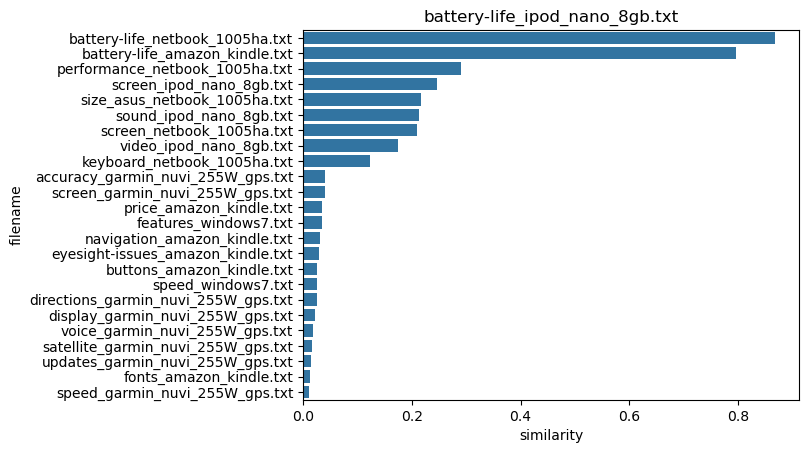

In [46]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# argsort()를 이용하여 앞예제의 첫번째 문서와 타 문서간 유사도가 큰 순으로 정렬한 인덱스 반환하되 자기 자신은 제외. 
sorted_index = similarity_pair.argsort()[:,::-1]
sorted_index = sorted_index[:, 1:]

# 유사도가 큰 순으로 hotel_indexes를 추출하여 재 정렬. 
hotel_sorted_indexes = hotel_indexes[sorted_index.reshape(-1)]

# 유사도가 큰 순으로 유사도 값을 재정렬하되 자기 자신은 제외
hotel_1_sim_value = np.sort(similarity_pair.reshape(-1))[::-1]
hotel_1_sim_value = hotel_1_sim_value[1:]

# 유사도가 큰 순으로 정렬된 Index와 유사도값을 이용하여 파일명과 유사도값을 Seaborn 막대 그래프로 시각화
hotel_1_sim_df = pd.DataFrame()
hotel_1_sim_df['filename'] = document_df.iloc[hotel_sorted_indexes]['filename']
hotel_1_sim_df['similarity'] = hotel_1_sim_value

sns.barplot(x='similarity', y='filename',data=hotel_1_sim_df)
plt.title(comparison_docname)

**8.9 한글 텍스트 처리**

In [48]:
import pandas as pd

train_df = pd.read_csv('./nsmc-master/ratings_train.txt', sep='\t')
train_df.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [49]:
train_df['label'].value_counts( )

label
0    75173
1    74827
Name: count, dtype: int64

In [51]:
import re

train_df = train_df.fillna(' ')
# 정규 표현식을 이용하여 숫자를 공백으로 변경(정규 표현식으로 \d 는 숫자를 의미함.) 
train_df['document'] = train_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# 테스트 데이터 셋을 로딩하고 동일하게 Null 및 숫자를 공백으로 변환
test_df = pd.read_csv('./nsmc-master/ratings_test.txt', sep='\t')
test_df = test_df.fillna(' ')
test_df['document'] = test_df['document'].apply( lambda x : re.sub(r"\d+", " ", x) )

# 개정판 소스 코드 변경(2019.12.24)
train_df.drop('id', axis=1, inplace=True) 
test_df.drop('id', axis=1, inplace=True)

In [53]:
from konlpy.tag import Twitter

twitter = Twitter()
def tw_tokenizer(text):
    # 입력 인자로 들어온 text 를 형태소 단어로 토큰화 하여 list 객체 반환
    tokens_ko = twitter.morphs(text)
    return tokens_ko

/opt/anaconda3/lib/python3.11/site-packages/konlpy/tag/_okt.py:17: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [54]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Twitter 객체의 morphs( ) 객체를 이용한 tokenizer를 사용. ngram_range는 (1,2) 
tfidf_vect = TfidfVectorizer(tokenizer=tw_tokenizer, ngram_range=(1,2), min_df=3, max_df=0.9)
tfidf_vect.fit(train_df['document'])
tfidf_matrix_train = tfidf_vect.transform(train_df['document'])

/opt/anaconda3/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:523: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [55]:
# Logistic Regression 을 이용하여 감성 분석 Classification 수행. 
lg_clf = LogisticRegression(random_state=0)

# Parameter C 최적화를 위해 GridSearchCV 를 이용. 
params = { 'C': [1 ,3.5, 4.5, 5.5, 10 ] }
grid_cv = GridSearchCV(lg_clf , param_grid=params , cv=3 ,scoring='accuracy', verbose=1 )
grid_cv.fit(tfidf_matrix_train , train_df['label'] )
print(grid_cv.best_params_ , round(grid_cv.best_score_,4))

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


{'C': 3.5} 0.8596


In [56]:
from sklearn.metrics import accuracy_score

# 학습 데이터를 적용한 TfidfVectorizer를 이용하여 테스트 데이터를 TF-IDF 값으로 Feature 변환함. 
tfidf_matrix_test = tfidf_vect.transform(test_df['document'])

# classifier 는 GridSearchCV에서 최적 파라미터로 학습된 classifier를 그대로 이용
best_estimator = grid_cv.best_estimator_
preds = best_estimator.predict(tfidf_matrix_test)

print('Logistic Regression 정확도: ',accuracy_score(test_df['label'],preds))

Logistic Regression 정확도:  0.86182
